<a href="https://colab.research.google.com/github/vladiouz/ai-generated-digits/blob/main/generate_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
def visualize_grid(tensor, number_of_channels=1, size=(28,28), number_of_images=16):
  data = tensor.detach().cpu().view(-1, number_of_channels, *size)
  grid = make_grid(data[:number_of_images], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

In [3]:
epochs = 500
current_step = 0
info_step = 300
mean_generator_loss = 0
mean_discriminator_loss = 0

z_dimension = 64
learning_rate = 0.00001
loss_function = nn.BCEWithLogitsLoss()


# how many images are we going to process at once
batch_size = 128

device = 'cuda'
dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=batch_size)


100%|██████████| 9912422/9912422 [00:00<00:00, 157123085.81it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119817699.13it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55154607.56it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20639792.81it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.nn.modules.activation import ReLU

# Generator

def generator_block(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.BatchNorm1d(output),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dimension=64, i_dimension=784, h_dimension=128):
    super().__init__()
    self.gen = nn.Sequential(
        generator_block(z_dimension, h_dimension),
        generator_block(h_dimension, h_dimension * 2),
        generator_block(h_dimension * 2, h_dimension * 4),
        generator_block(h_dimension * 4, h_dimension * 8),
        nn.Linear(h_dimension * 8, i_dimension),
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

def generate_noise(number_of_noise_vectors, z_dimension):
  return torch.randn(number_of_noise_vectors, z_dimension).to(device)

# Discriminator

def discriminator_block(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dimension=784, h_dimension=256):
    super().__init__()
    self.disc = nn.Sequential(
      discriminator_block(i_dimension, h_dimension * 4),
      discriminator_block(h_dimension * 4, h_dimension * 2),
      discriminator_block(h_dimension * 2, h_dimension),
      nn.Linear(h_dimension, 1)
    )

  def forward(self, image):
    return self.disc(image)



In [5]:
generator = Generator(z_dimension).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

discriminator = Discriminator().to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [6]:
generator

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 1, 4, 3, 0, 1, 1, 0, 7, 7])


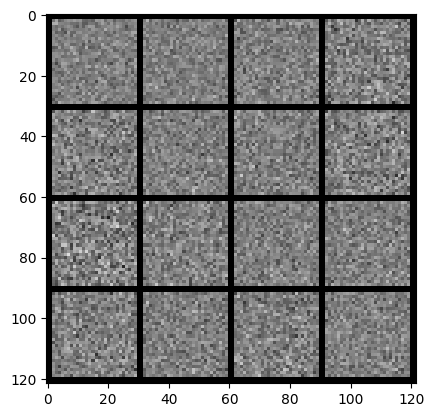

In [7]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = generate_noise(batch_size, z_dimension)
fake_image = generator(noise)
visualize_grid(fake_image)

In [8]:
def calculate_generator_loss(loss_function, generator, discriminator, batch_size, z_dimension):
  noise = generate_noise(batch_size, z_dimension)
  fake_image = generator(noise)
  prediction = discriminator(fake_image)
  target = torch.ones_like(prediction)
  generator_loss = loss_function(prediction, target)
  return generator_loss

def calculate_discriminator_loss(loss_function, generator, discriminator, batch_size, real_img, z_dimension):
  noise = generate_noise(batch_size, z_dimension)
  fake_image = generator(noise)
  discriminator_fake = discriminator(fake_image.detach())
  discriminator_fake_targets = torch.zeros_like(discriminator_fake)
  discriminator_fake_loss = loss_function(discriminator_fake, discriminator_fake_targets)

  discriminator_real = discriminator(real_img)
  discriminator_real_targets = torch.ones_like(discriminator_real)
  discriminator_real_loss = loss_function(discriminator_real, discriminator_real_targets)

  discriminator_loss = (discriminator_real_loss + discriminator_fake_loss) / 2
  return discriminator_loss

In [ ]:
for epoch in range(epochs):
  for real_img, _ in tqdm(dataloader):
    ### discriminator
    discriminator_optimizer.zero_grad()

    current_batch_size = len(real_img)
    real_img = real_img.view(current_batch_size, -1)
    real_img = real_img.to(device)

    discriminator_loss = calculate_discriminator_loss(loss_function, generator, discriminator, current_batch_size, real_img, z_dimension)
    discriminator_loss.backward(retain_graph=True)
    discriminator_optimizer.step()

    ### generator
    generator_optimizer.zero_grad()

    generator_loss = calculate_generator_loss(loss_function, generator, discriminator, current_batch_size, z_dimension)
    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    ### visualization
    mean_discriminator_loss += discriminator_loss.item()/info_step
    mean_generator_loss += generator_loss.item()/info_step

    if current_step % info_step == 0 and current_step > 0:
      fake_noise = generate_noise(current_batch_size, z_dimension)
      fake_img = generator(fake_noise)
      visualize_grid(fake_img)
      visualize_grid(real_img)
      print(f"{epoch} / Gen loss: {mean_generator_loss} / Disc loss: {mean_discriminator_loss}")
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    current_step += 1
